In [5]:
import os
import tarfile
from six.moves import urllib
# SE FIJAN LAS RUTAS DEL REPOSITIORIO DEL LIBRO
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [6]:
# AUTOMATIZAR LA DESCARGA Y EXTRACCION DEL ARCHIVO CON LA LIBRERIA TARFILE
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [7]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

In [8]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
housing["total_bedrooms"].isna().sum()

207

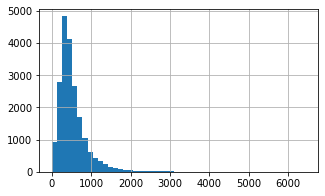

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
housing['total_bedrooms'].hist(bins=50, figsize=(5,3))
plt.show()

In [11]:
# ASI SE CREA UN TEST_SPLIT USANDO SOLO NUMPY
import numpy as np
shuffled_indices = np.random.permutation(len(housing))
test_set_size = int(len(housing) * 0.2)
test_indices = shuffled_indices[:test_set_size]
train_indices = shuffled_indices[test_set_size:]

In [12]:
housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0., 1.5, 3.0, 4.5, 6.,np.inf], 
                               labels=[1, 2, 3, 4, 5])

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
#     print(train_index, test_index)
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [21]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [25]:
copy = strat_train_set.copy()

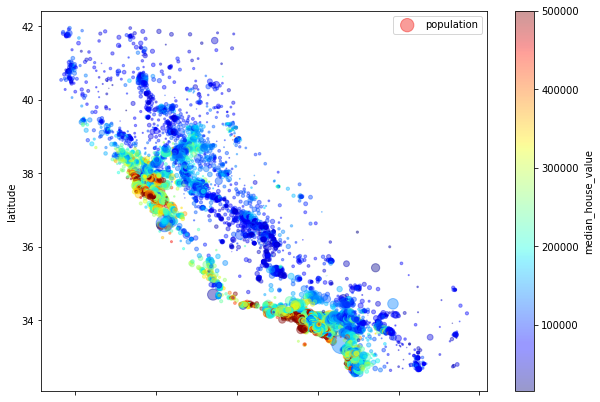

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population", figsize=(10,7),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()


In [41]:
import seaborn as sns
corr = copy.corr()
corr['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [42]:
copy['bedrooms_per_housing'] = copy['total_rooms']/copy['households']
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [43]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [51]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [57]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [65]:
housing_cat = housing[["ocean_proximity"]]
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([[0.],
       [0.],
       [4.],
       ...,
       [1.],
       [0.],
       [3.]])

In [68]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [72]:
housing_1hot = pd.DataFrame(housing_cat_1hot.toarray(), columns=encoder.categories_)